# **Exploración y limpieza de los datos**
A continuación, se realiza un análisis exploratorio para describir estadística y visualmente el comportamiento de las variables a considerar. Adicionalmente, se calculan estadísticas descriptivas y algunos diagramas que permiten comprender cómo se comportan las variables de interés.

## **1. Importación de los datos**
Estos se encuentran en formato `.csv`, se importa y se manejan como DataFrame con la libreria `pandas`.

In [53]:
import pandas as pd

df = pd.read_csv("incident_event_log.csv")
print(df.head())

       number incident_state  active  reassignment_count  reopen_count  \
0  INC0000045            New    True                   0             0   
1  INC0000045       Resolved    True                   0             0   
2  INC0000045       Resolved    True                   0             0   
3  INC0000045         Closed   False                   0             0   
4  INC0000047            New    True                   0             0   

   sys_mod_count  made_sla    caller_id       opened_by        opened_at  ...  \
0              0      True  Caller 2403    Opened by  8  29/2/2016 01:16  ...   
1              2      True  Caller 2403    Opened by  8  29/2/2016 01:16  ...   
2              3      True  Caller 2403    Opened by  8  29/2/2016 01:16  ...   
3              4      True  Caller 2403    Opened by  8  29/2/2016 01:16  ...   
4              0      True  Caller 2403  Opened by  397  29/2/2016 04:40  ...   

  u_priority_confirmation         notify problem_id rfc vendor cause

## **2. Preparación preliminar de los datos**
Se exploran los datos disponibles y se realiza una limpieza cuidadosa identificando especialmente datos duplicados o faltantes que puedan interrumpir o sesgar la generación de las gráficas. Asímismo, es importante asegurarnos de que los datos queden en un formato que permita su posterior análisis gráfico. 

In [54]:
# Ver si hay duplicados
print("¿Hay duplicados?:", df.duplicated().any())  # True si existe al menos un duplicado
print("Número de filas duplicadas:", df.duplicated().sum())

df = df.drop_duplicates()

# Ver si hay nulos
print("\nCantidad de nulos por columna:")
df.replace('?', pd.NA, inplace=True)
print(df.isnull().sum())

¿Hay duplicados?: False
Número de filas duplicadas: 0

Cantidad de nulos por columna:
number                          0
incident_state                  0
active                          0
reassignment_count              0
reopen_count                    0
sys_mod_count                   0
made_sla                        0
caller_id                      29
opened_by                    4835
opened_at                       0
sys_created_by              53076
sys_created_at              53076
sys_updated_by                  0
sys_updated_at                  0
contact_type                    0
location                       76
category                       78
subcategory                   111
u_symptom                   32964
cmdb_ci                    141267
impact                          0
urgency                         0
priority                        0
assignment_group            14213
assigned_to                 27496
knowledge                       0
u_priority_confirmation       

Aunque `df.isnull().sum()` nos dice que no existen nulos, luego de manipular los datos más adelante ocurría un problema con la columna `resolved_at` que originalmente tiene algunas celdas con el valor de tipo string `?`, razón por la que no se detectó como *null* pero que causa problemas al tratar esta columna como datos tipo `datetime`. Por esta razón, se decidió asignar la fecha de cierre para los inicidentes sin fecha de resolución.

In [55]:
# Resolver que hacer con las filas con celdas nulas. Sugerencia: llenar resolved_at con closed_at
df.fillna({'resolved_at': df['closed_at']}, inplace=True)

# Formatear las columnas que corresponden a fechas
df["opened_at"] = pd.to_datetime(df["opened_at"], format="%d/%m/%Y %H:%M")
df["resolved_at"] = pd.to_datetime(df["resolved_at"], format="%d/%m/%Y %H:%M")
df["closed_at"] = pd.to_datetime(df["closed_at"], format="%d/%m/%Y %H:%M")

Asimismo, se hizo importante construir un DataFrame aparte que incluyera los incidentes una sola vez, esto para calcular métricas como el **tiempo de resolución** y sacar algunos gráficos de interés. Esto evita que los datos se vean duplicados por la cantidad de veces que el incidente recibió una actualización.

In [56]:
# Crear un único registro por incidente
df_unicos = df.drop_duplicates(subset="number", keep="last").copy()

# Crear variable de duración en horas
df_unicos["resolution_time"] = (df_unicos["resolved_at"] - df_unicos["opened_at"]).dt.total_seconds() / 3600 / 24 

df_unicos.head() 
#print(df_unicos.shape)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,resolution_time
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,...,Do Not Notify,<NA>,<NA>,<NA>,<NA>,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,0.425694
12,INC0000047,Closed,False,1,0,8,True,Caller 2403,Opened by 397,2016-02-29 04:40:00,...,Do Not Notify,<NA>,<NA>,<NA>,<NA>,code 5,Resolved by 81,2016-03-01 09:52:00,2016-03-06 10:00:00,1.216667
19,INC0000057,Closed,False,0,0,6,True,Caller 4416,Opened by 8,2016-02-29 06:10:00,...,Do Not Notify,Problem ID 2,<NA>,<NA>,<NA>,code 10,Resolved by 5,2016-03-01 02:55:00,2016-03-06 03:00:00,0.864583
23,INC0000060,Closed,False,0,0,3,True,Caller 4491,Opened by 180,2016-02-29 06:38:00,...,Do Not Notify,<NA>,<NA>,<NA>,<NA>,code 3,Resolved by 113,2016-03-02 12:06:00,2016-03-07 13:00:00,2.227778
31,INC0000062,Closed,False,1,0,7,False,Caller 3765,Opened by 180,2016-02-29 06:58:00,...,Do Not Notify,<NA>,<NA>,<NA>,<NA>,code 7,Resolved by 62,2016-02-29 15:51:00,2016-03-05 16:00:00,0.370139


Por último, se hace revisión de algunas estadisticas descriptivas, especialmente para las **variables numéricas**.

In [57]:
df.describe()

,reassignment_count,reopen_count,sys_mod_count,opened_at,resolved_at,closed_at
count,141712.000000,141712.000000,141712.000000,141712,141712,141712
mean,1.104197,0.021918,5.080946,2016-04-12 22:19:09.100852736,2016-04-24 01:36:28.878852864,2016-04-29 23:48:41.171248640
min,0.000000,0.000000,0.000000,2016-02-29 01:16:00,2016-02-29 09:04:00,2016-02-29 17:47:00
25%,0.000000,0.000000,1.000000,2016-03-16 15:24:00,2016-03-26 08:16:00,2016-03-31 09:59:00
50%,1.000000,0.000000,3.000000,2016-04-07 16:27:00,2016-04-15 11:38:00,2016-04-20 13:07:00
75%,1.000000,0.000000,6.000000,2016-05-04 10:32:00,2016-05-12 11:13:00,2016-05-17 13:07:00
max,27.000000,8.000000,129.000000,2017-02-16 14:17:00,2017-02-17 00:47:00,2017-02-18 15:00:00
std,1.734673,0.207302,7.680652,NaN,NaN,NaN


In [58]:
df_unicos.describe()

,reassignment_count,reopen_count,sys_mod_count,opened_at,resolved_at,closed_at,resolution_time
count,24918.000000,24918.000000,24918.000000,24918,24918,24918,24918.000000
mean,0.939642,0.013284,6.684606,2016-04-15 16:17:42.879845888,2016-04-23 01:37:51.326751744,2016-04-28 19:37:25.961954816,7.388987
min,0.000000,0.000000,1.000000,2016-02-29 01:16:00,2016-02-29 09:04:00,2016-02-29 17:47:00,0.000000
25%,0.000000,0.000000,2.000000,2016-03-21 14:59:00,2016-03-29 00:04:00,2016-04-02 15:59:00,0.020833
50%,0.000000,0.000000,4.000000,2016-04-12 15:27:00,2016-04-18 10:07:00,2016-04-23 11:07:00,1.072917
75%,1.000000,0.000000,8.000000,2016-05-05 14:48:45,2016-05-11 12:48:45,2016-05-16 15:07:00,6.072917
max,27.000000,8.000000,129.000000,2017-02-16 14:17:00,2017-02-17 00:47:00,2017-02-18 15:00:00,336.256944
std,1.572035,0.148922,8.549914,NaN,NaN,NaN,21.554668


## **3. Visualización de los datos con gráficos**
Para tener una visión más amplia y concluyente de los datos, se proponen gráficos como histogramas, diagramas de caja, diagramas de dispersión, diagramas de violín y demás que permitan comprender cómo se comportan las variables. Iniciamos con la importación de algunas librerias relevantes en este caso como lo son `matplotlib` y `seaborn`.

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

## **3.1. Tiempo de resolución vs cumplimiento del SLA**
### **Histograma del tiempo de resolución en días según el cumplimiento de SLA**

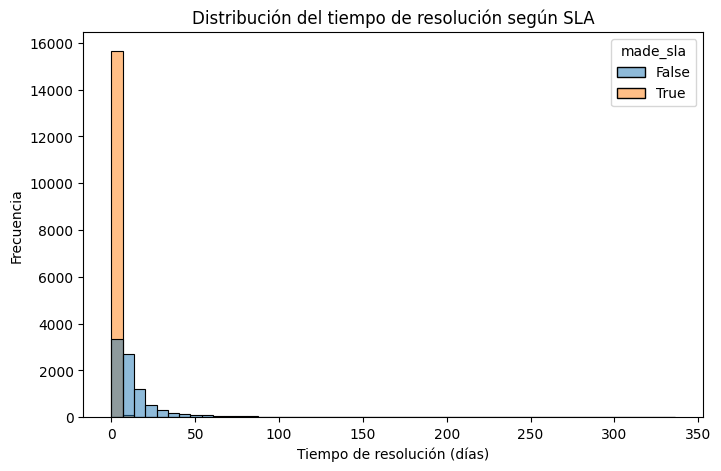

In [60]:
plt.figure(figsize=(8,5))
sns.histplot(data=df_unicos, x="resolution_time", hue="made_sla", bins=50, kde=False)
plt.title("Distribución del tiempo de resolución según SLA")
plt.xlabel("Tiempo de resolución (días)")
plt.ylabel("Frecuencia")
plt.show()

## **3.2. Efectividad de la clasificación y atención del incidente**
### **Diagrama de barras para el tiempo promedio de resolución por prioridad vs urgencia reportada**

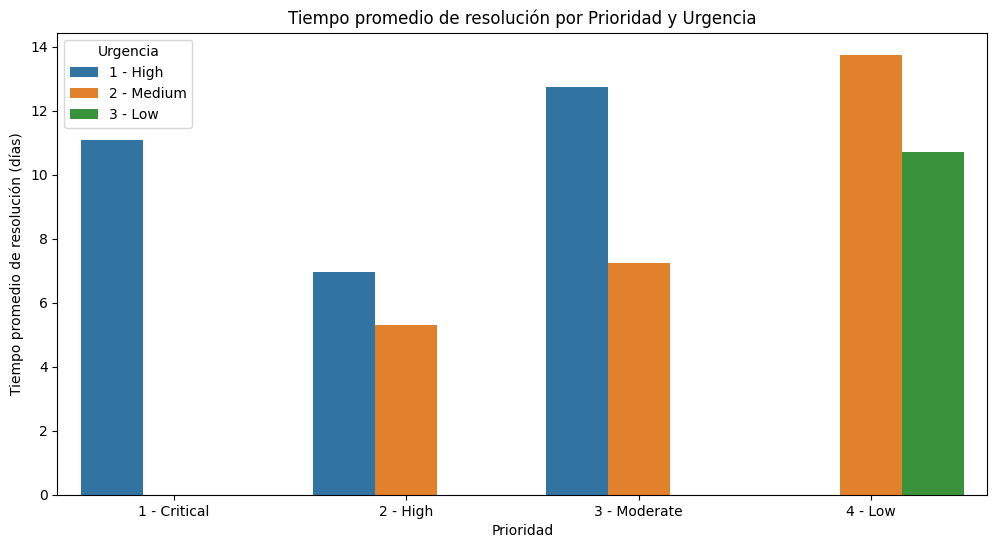

In [61]:
# Agrupar por prioridad y urgencia
avg_time_group = (
    df_unicos.groupby(["priority", "urgency"])["resolution_time"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.barplot(
    x="priority",
    y="resolution_time",
    hue="urgency",  
    data=avg_time_group
)

plt.title("Tiempo promedio de resolución por Prioridad y Urgencia")
plt.xlabel("Prioridad")
plt.ylabel("Tiempo promedio de resolución (días)")
plt.legend(title="Urgencia")
plt.show()


### **Diagrama de barras para el tiempo promedio de resolución por prioridad vs impacto causado**

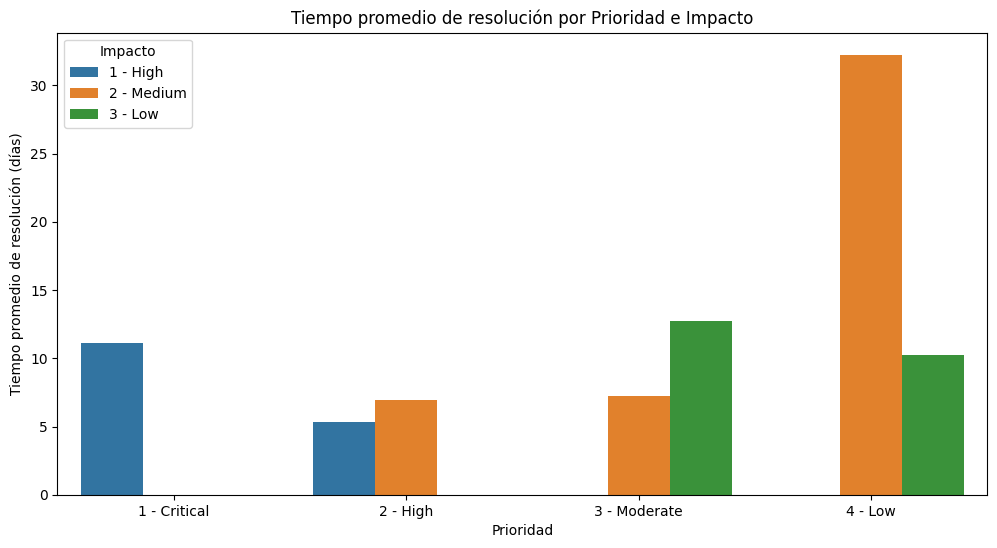

In [62]:
# Agrupar por prioridad e impacto
avg_time_group = (
    df_unicos.groupby(["priority", "impact"])["resolution_time"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.barplot(
    x="priority",
    y="resolution_time",
    hue="impact",  
    data=avg_time_group
)

plt.title("Tiempo promedio de resolución por Prioridad e Impacto")
plt.xlabel("Prioridad")
plt.ylabel("Tiempo promedio de resolución (días)")
plt.legend(title="Impacto")
plt.show()

### **Diagrama de torta para la cantidad de incidentes por clasificación de prioridad**

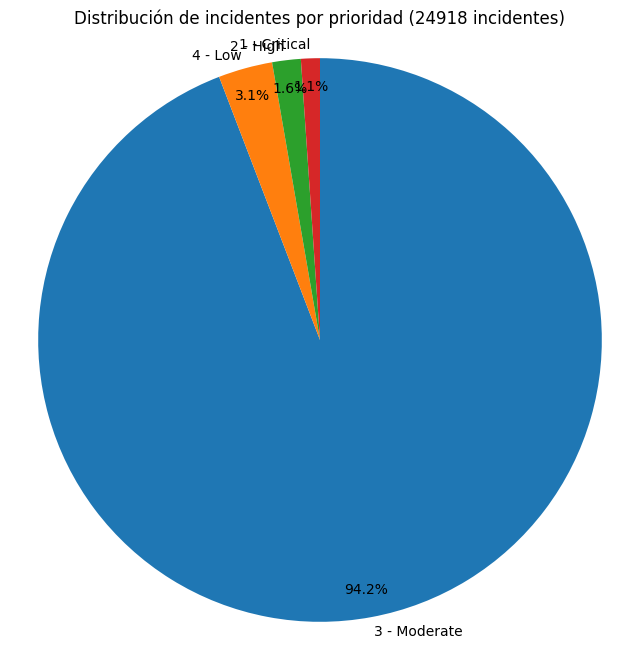

In [63]:
counts = df_unicos["priority"].fillna("Unknown").value_counts()

plt.figure(figsize=(8,8))
plt.pie(
    counts.values,
    labels=counts.index,
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False,
    labeldistance=1.05,
    pctdistance=0.9
)
plt.title("Distribución de incidentes por prioridad ({} incidentes)".format(counts.sum()))
plt.axis("equal") 
plt.show()

### **Heatmap del porcentaje del SLA cumplido por categoría según prioridad**

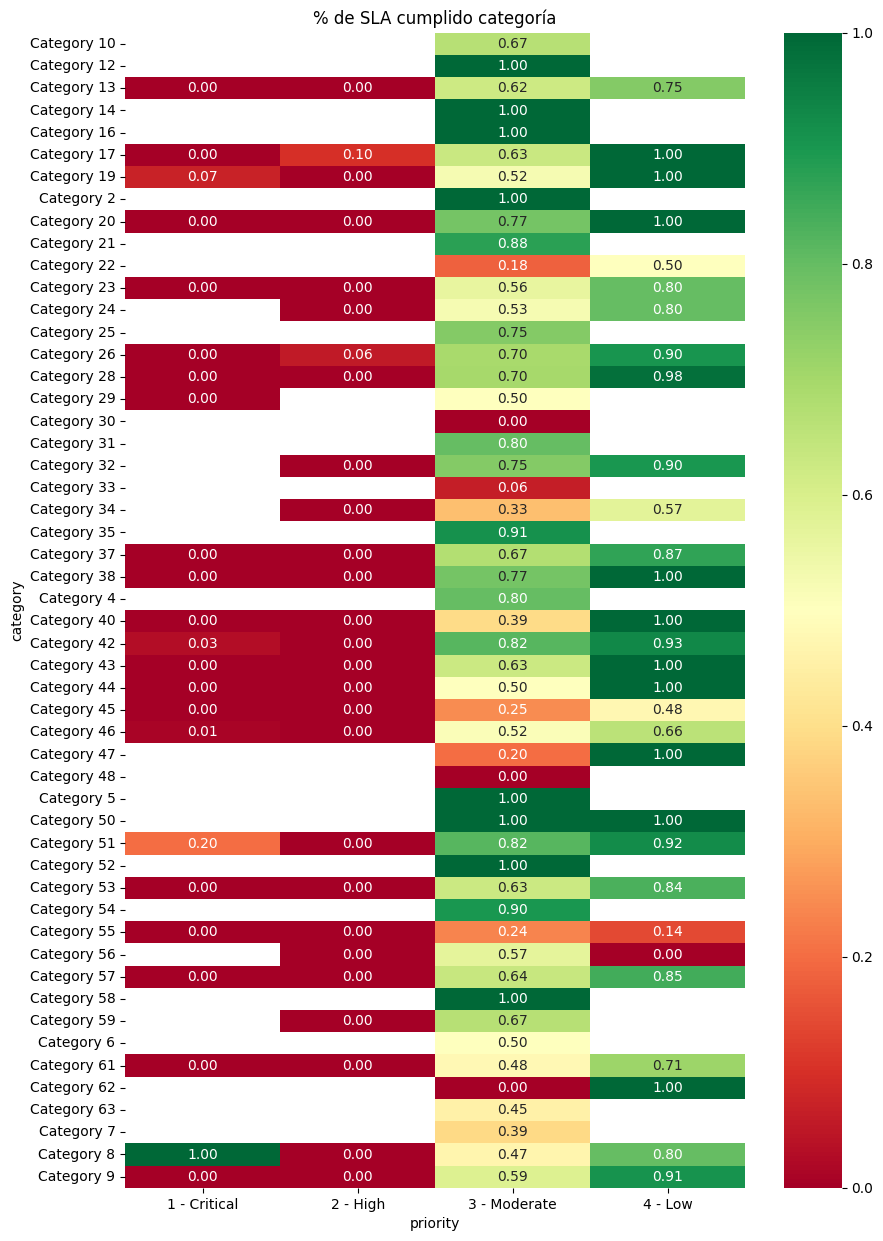

In [64]:
sla_group_cat = df_unicos.pivot_table(
    index="category",
    columns="priority",
    values="made_sla",
    aggfunc="mean"
)

plt.figure(figsize=(10,15))
sns.heatmap(sla_group_cat, annot=True, cmap="RdYlGn", fmt=".2f")
plt.title("% de SLA cumplido categoría")
plt.show()

### **Heatmap del porcentaje del SLA cumplido según la urgencia del cliente y la prioridad**

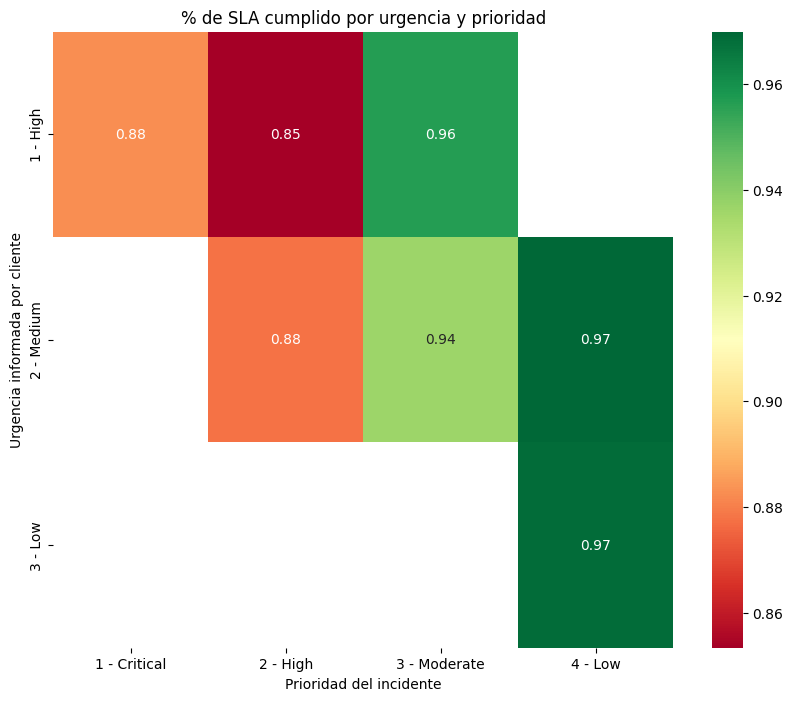

In [65]:
sla_group_cat = df.pivot_table(
    index="urgency",
    columns="priority",
    values="made_sla",
    aggfunc="mean"
)

plt.figure(figsize=(10,8))
sns.heatmap(sla_group_cat, annot=True, cmap="RdYlGn", fmt=".2f")
plt.title("% de SLA cumplido por urgencia y prioridad")
plt.xlabel("Prioridad del incidente")
plt.ylabel("Urgencia informada por cliente")
plt.show()

### **Heatmap del tiempo promedio de resolución (días) según la urgencia del cliente y la prioridad**

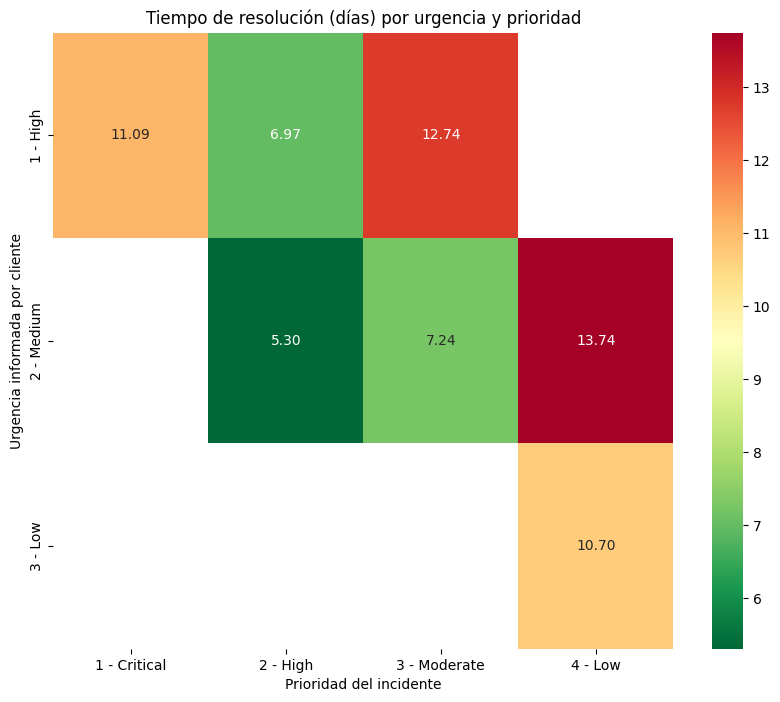

In [66]:
sla_group_cat = df_unicos.pivot_table(
    index="urgency",
    columns="priority",
    values="resolution_time",
    aggfunc="mean"
)

plt.figure(figsize=(10,8))
sns.heatmap(sla_group_cat, annot=True, cmap="RdYlGn_r", fmt=".2f")
plt.title("Tiempo de resolución (días) por urgencia y prioridad")
plt.xlabel("Prioridad del incidente")
plt.ylabel("Urgencia informada por cliente")
plt.show()

### **Diagrama de torta de la distribución del uso de conocimiento según si se cumple el SLA**

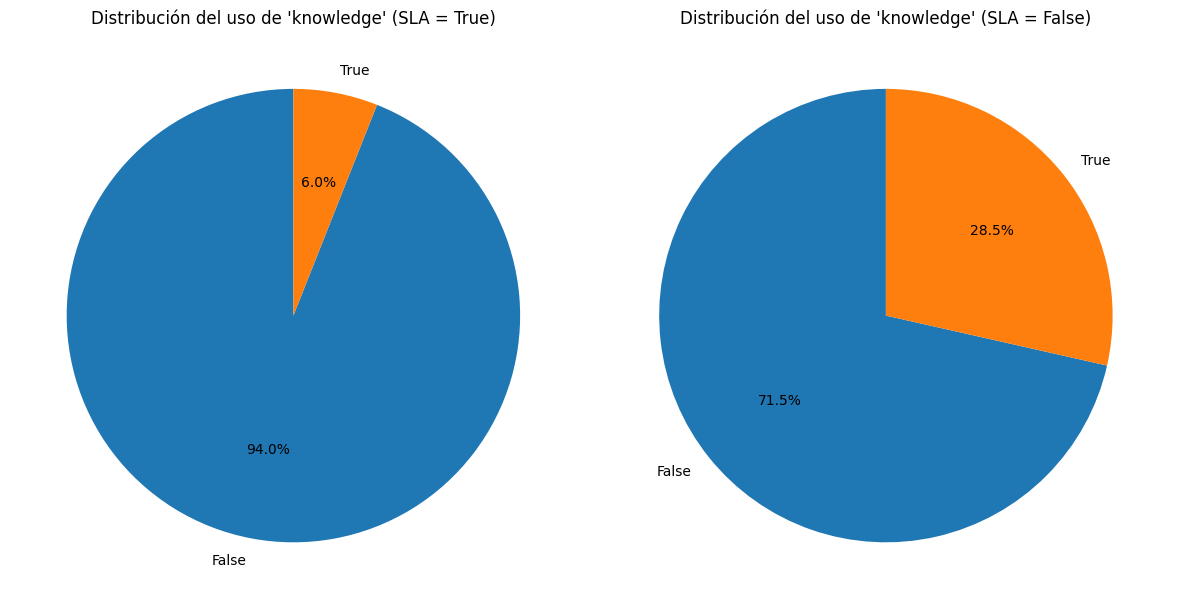

In [67]:
# Tabulación cruzada knowledge vs SLA
tabla = pd.crosstab(df_unicos['knowledge'], df_unicos['made_sla'])

# Preparar figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# --- Pie para SLA=True ---
if True in tabla.columns:
    axes[0].pie(
        tabla[True],
        labels=tabla.index.astype(str),
        autopct='%1.1f%%',
        startangle=90
    )
    axes[0].set_title("Distribución del uso de 'knowledge' (SLA = True)")

# --- Pie para SLA=False ---
if False in tabla.columns:
    axes[1].pie(
        tabla[False],
        labels=tabla.index.astype(str),
        autopct='%1.1f%%',
        startangle=90
    )
    axes[1].set_title("Distribución del uso de 'knowledge' (SLA = False)")

plt.tight_layout()
plt.show()


## **3.3. Areas con mayor cantidad de incidentes**
### **Histograma del top 15 grupos con más incidentes**

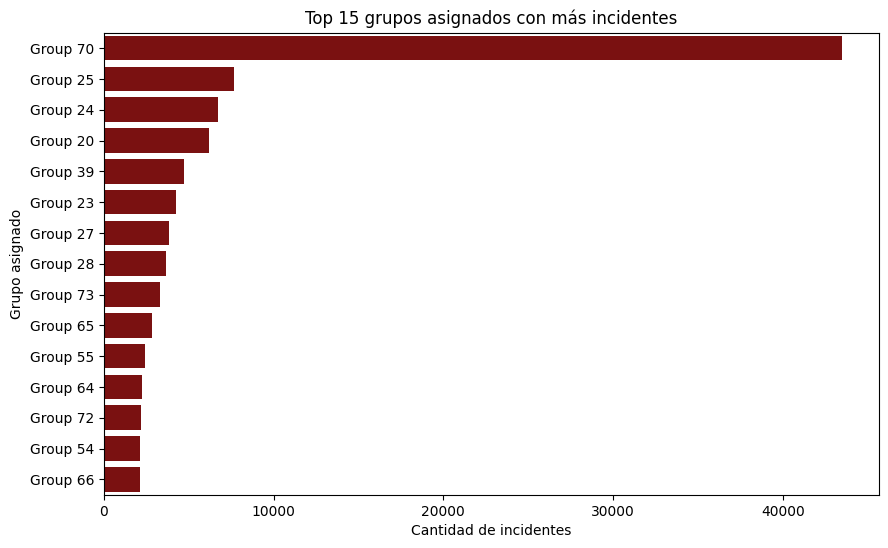

In [68]:
plt.figure(figsize=(10,6))
top_cat = df["assignment_group"].value_counts().head(15)
sns.barplot(x=top_cat.values, y=top_cat.index, color="darkred")
plt.title("Top 15 grupos asignados con más incidentes")
plt.ylabel("Grupo asignado")
plt.xlabel("Cantidad de incidentes")
plt.show()

### **Histograma del top 15 categorías con más incidentes**

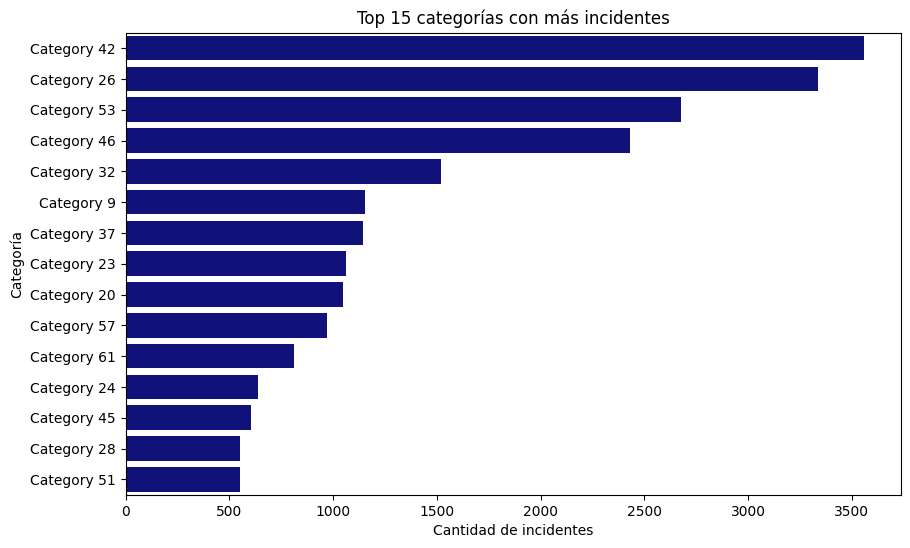

In [69]:
plt.figure(figsize=(10,6))
top_cat = df_unicos["category"].value_counts().head(15)
sns.barplot(x=top_cat.values, y=top_cat.index, color="darkblue")
plt.title("Top 15 categorías con más incidentes")
plt.ylabel("Categoría")
plt.xlabel("Cantidad de incidentes")
plt.show()

### **Histograma del top 15 subcategorías con más incidentes**

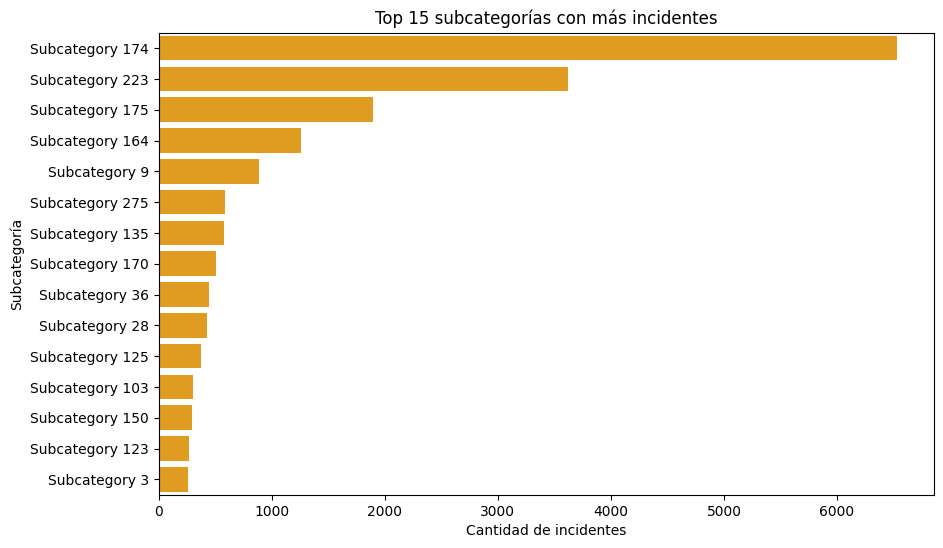

In [70]:
plt.figure(figsize=(10,6))
top_subcat = df_unicos["subcategory"].value_counts().head(15)
sns.barplot(x=top_subcat.values, y=top_subcat.index, color="orange")
plt.title("Top 15 subcategorías con más incidentes")
plt.ylabel("Subcategoría")
plt.xlabel("Cantidad de incidentes")
plt.show()

## **3.4. Relación entre otras variables**
### **Diagrama de dispersión del tiempo de resolución y la categoría del incidente**

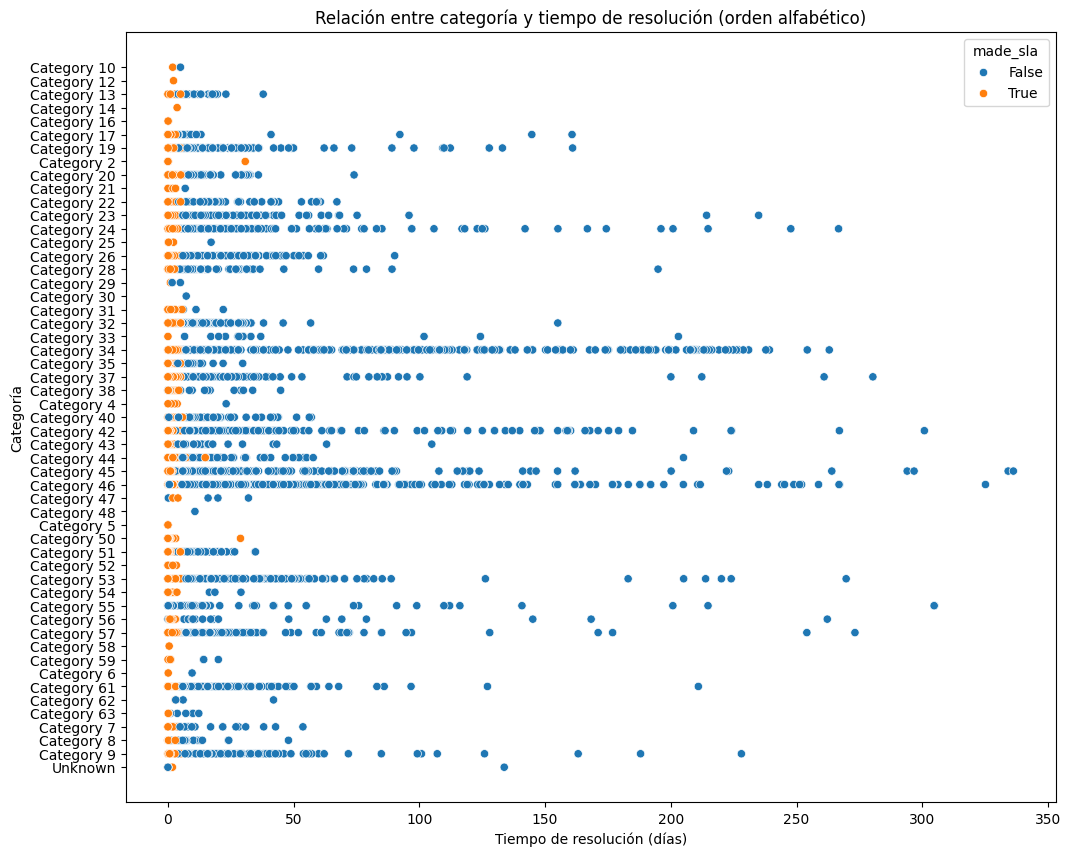

In [71]:
df_unicos["category"] = df_unicos["category"].fillna("Unknown")

# Ordenar alfabéticamente las categorías
ordered = sorted(df_unicos["category"].unique())

# Convertir la columna en categoría con orden explícito
df_unicos["category"] = pd.Categorical(df_unicos["category"], categories=ordered, ordered=True)

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=df_unicos,
    x="resolution_time",
    y="category",
    hue="made_sla",
)
plt.title("Relación entre categoría y tiempo de resolución (orden alfabético)")
plt.xlabel("Tiempo de resolución (días)")
plt.ylabel("Categoría")
plt.show()


### **Diagrama de dispersión del tiempo de resolución y la cantidad de modificaciones**

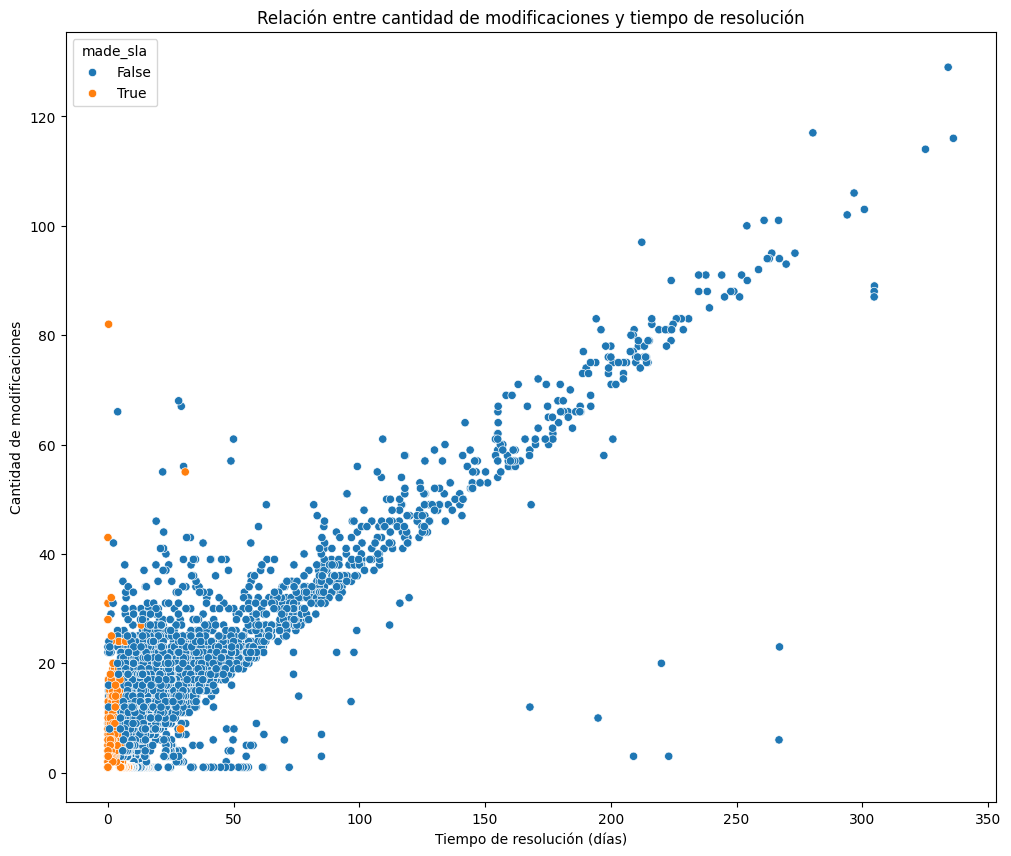

In [72]:
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=df_unicos,
    x="resolution_time",
    y="sys_mod_count",
    hue="made_sla",
)
plt.title("Relación entre cantidad de modificaciones y tiempo de resolución")
plt.xlabel("Tiempo de resolución (días)")
plt.ylabel("Cantidad de modificaciones")
plt.show()

### **Matriz de correlación entre el cumplimiento del SLA y demás variables de interés**

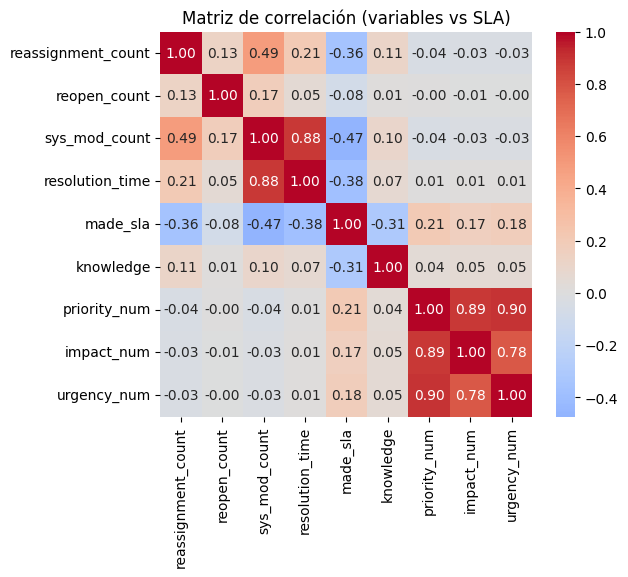

In [73]:
# Mapeo ordinal
level_map = {"1 - High": 3, "2 - Medium": 2, "3 - Low": 1, 
              "1 - Critical": 4, "2 - High": 3, "3 - Moderate": 2, "4 - Low": 1}

def to_ordinal(series):
    s = series.astype(str).str.strip().str.lower()

    mapped = s.map(level_map)
    # si quedan valores como '1','2','3' extraer dígito inicial
    digits = s.str.extract(r"^(\d+)")[0]
    mapped = mapped.fillna(pd.to_numeric(digits, errors="coerce"))
    return mapped.astype("Int64")  # permite nulos si existieran

cols = ["priority", "impact", "urgency"]
for c in cols:
    df_unicos[c + "_num"] = to_ordinal(df_unicos[c])

# Ahora usar las columnas *_num para la correlación
df_corr = df_unicos[[
    "reassignment_count", "reopen_count", "sys_mod_count", "resolution_time",
    "made_sla", "knowledge", "priority_num", "impact_num", "urgency_num"]].copy()

# Convertir made_sla a 0/1 y asegurar tipo numérico
df_corr["made_sla"] = df_corr["made_sla"].astype(int)
df_corr["knowledge"] = df_corr["knowledge"].astype(int)
df_corr = df_corr.astype(float)

# Calcular matriz de correlación
corr = df_corr.corr()

# Graficar heatmap
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Matriz de correlación (variables vs SLA)")
plt.show()
